# Image compression - part 1. - PCA
In this post I will be briefly looking at PCA as a means to compress images.
Images are a matrix of pixels, where each value corresponds to some brightness.
Image compression typically involves representing those pixels in fewer dimensions than the original.

PCA is a means of dimensionality reduction commonly used in statistical applications.
I assume the reader is already familiar with the PCA algorithm and here I will look at applying it to images.
I may explore further techniques in the future, so this is a preliminary part 1...

We'll do this analysis on the ever popular and omnipresent MNIST dataset.
First let's download the required dataset.

In [1]:
from pathlib import Path
import torch
import torchvision

transform = torchvision.transforms.Compose(
    [
        torchvision.transforms.ToTensor()
    ]
)

mnist_train_data = torchvision.datasets.MNIST(
    Path() / "data", train=True, download=True, transform=transform
)
mnist_train = torch.utils.data.DataLoader(mnist_train_data, batch_size=64)

/Users/Rich/Developer/miniconda3/envs/pytorch_env/lib/python3.9/site-packages/torchvision/datasets/mnist.py:498: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  ../torch/csrc/utils/tensor_numpy.cpp:180.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


We can show some images to check we've got that correct.

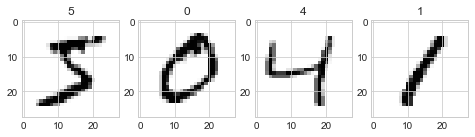

In [2]:
# inspect first batch
dataiter = iter(mnist_train)
images, labels = dataiter.next()

import matplotlib.pyplot as plt

plt.style.use("seaborn-whitegrid")

fig, ax = plt.subplots(figsize=(8, 16), ncols=4)
for col in range(0,4):
    ax[col].imshow(images[col, 0])
    ax[col].set_title(str(labels[col].numpy()))

## Running PCA
In order to fit the data with PCA we will change the DataLoader batch size to return all the images.
This gives us 60,000 images.
Then we will reshape each images, so it is in a single vector instead of a matrix.
The ordering of the pixels is not important in the PCA algorithm.

In [3]:
# small dataset, so we can load it all at once
dataloader = torch.utils.data.DataLoader(
    dataset=mnist_train_data, batch_size=len(mnist_train_data)
)
images_all, labels_all = next(iter(dataloader))

# convert to 1D
images_flat = images_all[:, 0].reshape(-1, 784).numpy()
images_flat.shape

(60000, 784)

We have 28*28 = 784 pixels per image, which means a dimension of 784.
With PCA this will give us 784 components.
In the following we will fit the data with PCA.
We will transform the images into the component domain.
Then we inverse transform from the component domain back to get a reconstruction of the original image.

We will repeat the above with only using the first n components.
In each case we can measure the reconstruction error.

In [4]:
import numpy as np
import pandas as pd
import sklearn.decomposition
import sklearn.metrics


component_range = np.array(list(range(1, 11)) + [50, 100, 200, 500])

print(f"training components: {component_range.max()}")
pca = sklearn.decomposition.PCA(n_components=component_range.max())
images_flat_hat = pca.inverse_transform(pca.fit_transform(images_flat))


def transform_truncated(pca, X, n_components):
    X = pca._validate_data(X, dtype=[np.float64, np.float32], reset=False)
    if pca.mean_ is not None:
        X = X - pca.mean_
    X_transformed = np.dot(X, pca.components_[:n_components, :].T)
    if pca.whiten:
        X_transformed /= np.sqrt(pca.explained_variance_)
    return X_transformed


def inv_transform(pca, X, n_components):
    return np.dot(X, pca.components_[:n_components, :]) + pca.mean_


def inv_forward_transform(pca, X, n_components):
    return inv_transform(
        pca, transform_truncated(pca, X, n_components), n_components
    )

# get reconstruction error for different n_components
mse_train_pca = []
for n in component_range:
    print(f"mse: {n}")
    images_flat_hat = inv_forward_transform(pca, X=images_flat, n_components=n)
    _loss = sklearn.metrics.mean_squared_error(images_flat_hat, images_flat)
    mse_train_pca.append(_loss)

training components: 500
mse: 1
mse: 2
mse: 3
mse: 4
mse: 5
mse: 6
mse: 7
mse: 8
mse: 9
mse: 10
mse: 50
mse: 100
mse: 200
mse: 500


Plotting the results show how with more components we get closer to the original images.
We plot the % of explained variance and the reconstruction error.

Text(0, 0.5, 'MSE')

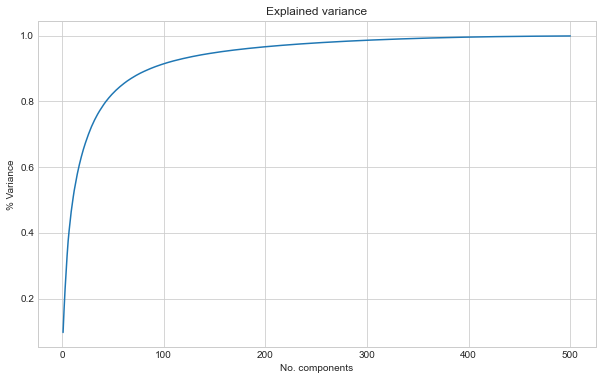

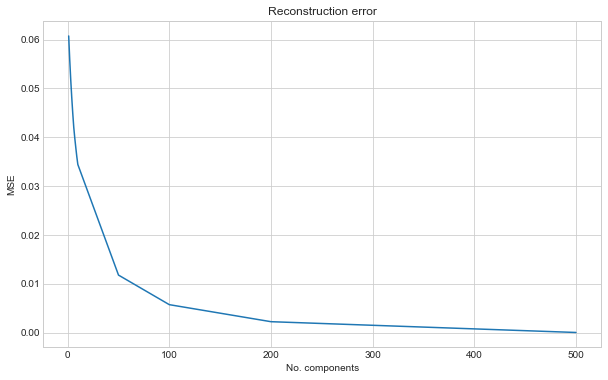

In [5]:
# explained variance
fig, ax = plt.subplots(figsize=(10, 6))
ax.plot(
    range(1, pca.n_components_ + 1), np.cumsum(pca.explained_variance_ratio_)
)
ax.set_title("Explained variance")
ax.set_xlabel("No. components")
ax.set_ylabel("% Variance")

# reconstruction mse
fig, ax = plt.subplots(figsize=(10, 6))
ax.plot(component_range, mse_train_pca)
ax.set_title("Reconstruction error")
ax.set_xlabel("No. components")
ax.set_ylabel("MSE")

We can show some images at various number of components to see what the images look like

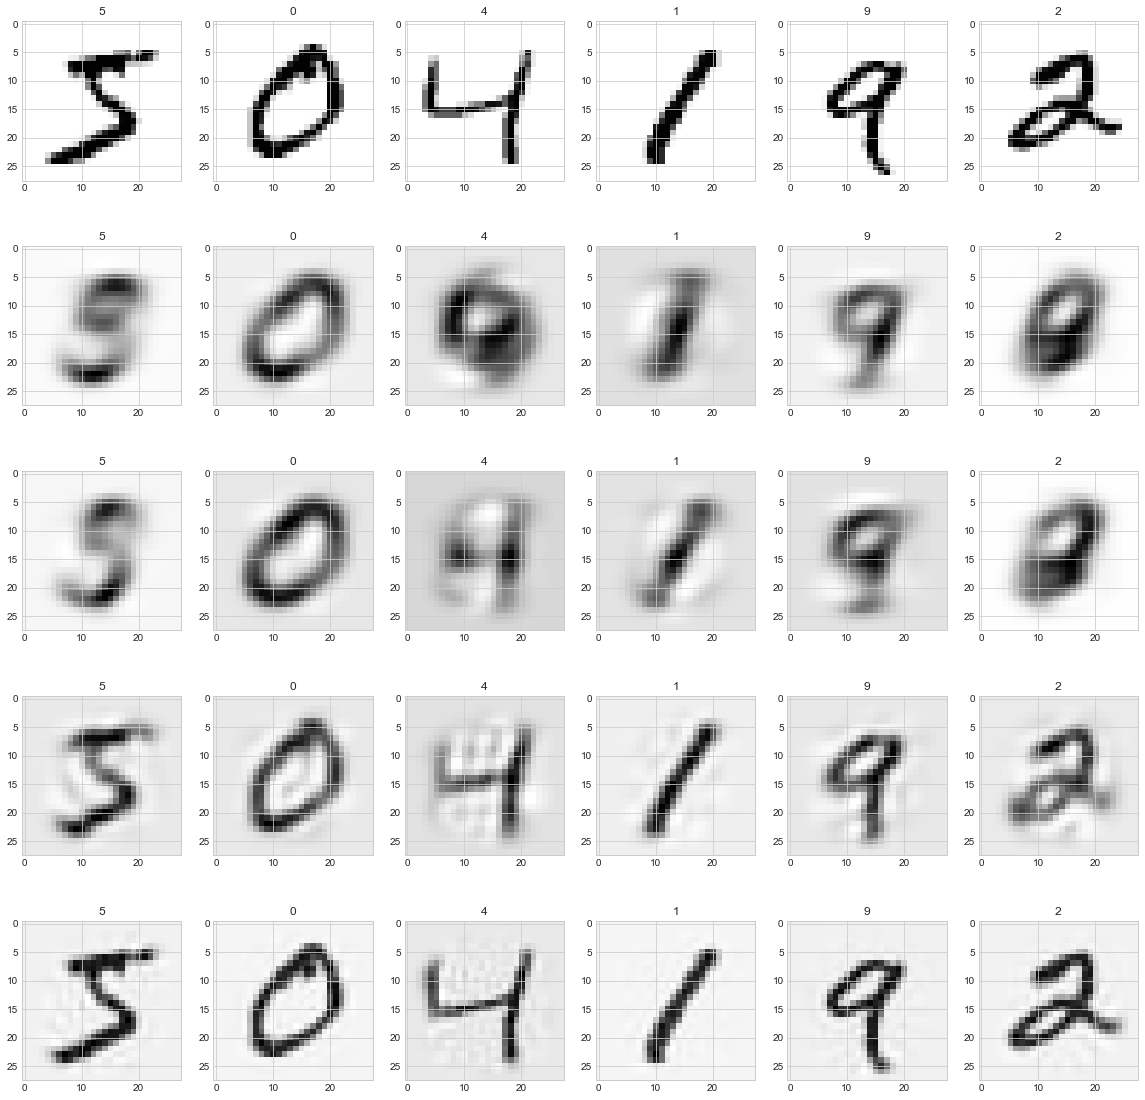

In [6]:
"""
truth 1, 2, 3, 4...
pca5  1, 2, 3, 4...
pca10 1, 2, 3, 4...
pca50 1, 2, 3, 4...
"""

fig, ax = plt.subplots(figsize=(20, 20), ncols=6, nrows=5)

for row, n_components in enumerate([5, 10, 50, 200]):
    images_hat = inv_forward_transform(
        pca, X=images_flat, n_components=n_components
    ).reshape(-1, 28, 28)

    for col in range(6):
        ax[0, col].imshow(images_all[col, 0])
        ax[0, col].set_title(str(labels_all[col].numpy()))

        ax[row + 1, col].imshow(images_hat[col])
        ax[row + 1, col].set_title(str(labels_all[col].numpy()))

As the components increase the digits look visably clearer.
Some digits look worse than others.
We can plot the MSE against the digit to see which are hard to construct:

Text(0, 0.5, 'MSE')

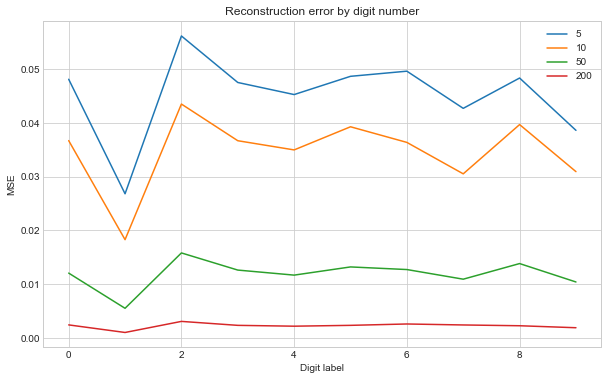

In [7]:
# MSE against label
loss_label = []
for row, n_components in enumerate([5, 10, 50, 200]):
    images_flat_hat = inv_forward_transform(
        pca, X=images_flat, n_components=n_components
    )

    _loss_label = []
    for label in range(0, 10):
        filt = labels_all == label
        _loss = sklearn.metrics.mean_squared_error(
            images_flat_hat[filt], images_flat[filt]
        )
        _loss_label.append(_loss)
    loss_label.append(_loss_label)

df_loss = pd.DataFrame(
    loss_label, index=[5, 10, 50, 200], columns=range(0, 10)
).transpose()
fig, ax = plt.subplots(figsize=(10, 6))
df_loss.plot(ax=ax)
ax.set_title("Reconstruction error by digit number")
ax.set_xlabel("Digit label")
ax.set_ylabel("MSE")

As expected increasing the number of components we use makes all the digits improve.
Looks like '1' is quite easy compared to the rest, whilst '2' is harder.